# Recognising NRs


In [22]:
import sys
import os

wdirs = ["/mnt/data/Anastasia/Glass","/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/",
"/mnt/data/Anastasia/QDs_prelabsem1811/","/mnt/data/Anastasia/Initial/",
"/mnt/data/Anastasia/test_18_07_11_pd29_06_div12_WISSNR/"]

dfiles = []
for dirt in wdirs:
    basedir = dirt
    files = os.listdir(basedir)
    if dirt[-1] != '/':
        dirt = dirt+'/'
    for f in files:
        if f[-4:]=='.tif': 
            try:
                i = int(f[-5])
                dfiles.append(dirt+f)
            except:
                pass

            
dfiles = dfiles[4:7]




In [2]:
sys.path.append("/export/home1/users/bssn/serna/GitIBENS/Nanorods")

In [3]:
from numpy import *
from matplotlib.pylab import *
import scipy.optimize as opt
import pickle
from scipy.optimize import minimize,least_squares
from scipy.stats import linregress

%matplotlib inline

In [4]:
from signal_analysis.core import dblgausfit,dblgaussd

In [23]:
dataL = []
nwdirs = []
for i,cfile in enumerate(dfiles):
    wdir = ''
    cf2 = cfile.split(".")[0].split("/")
    for fs in cf2[:-1]:
        wdir = wdir+fs+'/'
    wdir = wdir+cf2[-1]+'output/sptrack/'
    nwdirs.append(wdir)
    
    with open(wdir+'data_msd.pickle', 'rb') as handle:
        datat = pickle.load(handle)
    
    dataL.append(datat)

In [14]:
def bimod(x):
    m1 = mean(x)
    m2 = std(x)
    m3 = mean((x-m1)**3)/m2**3
    m4 = mean((x-m1)**4)/m2**4
    return((m3**2+1)/m4)

In [61]:
dfilesF = []
for i,dirt in enumerate(nwdirs):
    basedir = dirt
    files = os.listdir(basedir)
    dfiles = []
    if driftcorrected:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfiles.append(basedir+f)
    else:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfiles.append(basedir+f)
    dfiles.sort()
    dfilesF.extend(dfiles)

In [16]:
driftcorrected = True

for i,dirt in enumerate(nwdirs):
    basedir = dirt
    files = os.listdir(basedir)
    dfiles = []
    if driftcorrected:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfiles.append(basedir+f)
    else:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfiles.append(basedir+f)
    dfiles.sort()

    dgpt = []
    idxt = []
    amps = []
    for ni,name in enumerate(dfiles):
        popts = load(name)
        posx = popts[:,5]
        posy = popts[:,6]
        amp = popts[:,0]
        th = 0
        th2 = 13.0
        sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
        Tf = len(posx)
        if sel.sum() > 1000:
            amps.append([mean(amp[sel]),mean(popts[sel,4]),bimod(amp[sel])])
            idxt.append(ni)

            m1,m2 = (mean(amp[sel]),std(amp[sel]))
            am = (amp[sel]-m1)/m2
            h = histogram(am,arange(min(am),max(am),0.2))
            hd = h[0]/sum(h[0])/0.2
            hx = (h[1][1:]+h[1][:-1])/2.0
            dgfit = dblgausfit(hx,hd,par0=array([0.5,-1,.5,1,.5]))
            dgpt.append(concatenate(([m1,m2],dgfit.x)))
            #if ni<15:
            #    plot(hx,hd,'.')
            #    plot(linspace(-4,4,100),dblgaussd(linspace(-4,4,100),dgfit.x))
            #else:
            #    break
            
    if i == 0:
        dgps = column_stack((array(dgpt),zeros(len(dgpt))+i))
        ampst = column_stack((array(amps),zeros(len(dgpt))+i))
        idx0 = array(idxt)
    else:
        dgps = row_stack((dgps,column_stack((array(dgpt),zeros(len(dgpt))+i))))
        ampst = row_stack((ampst,column_stack((array(amps),zeros(len(dgpt))+i))))
        idx0 = concatenate((idx0,array(idxt)+idx0[-1]+1))
        

In [17]:
dgps.shape

(3803, 8)

(3786,)


Text(0,0.5,'p_1')

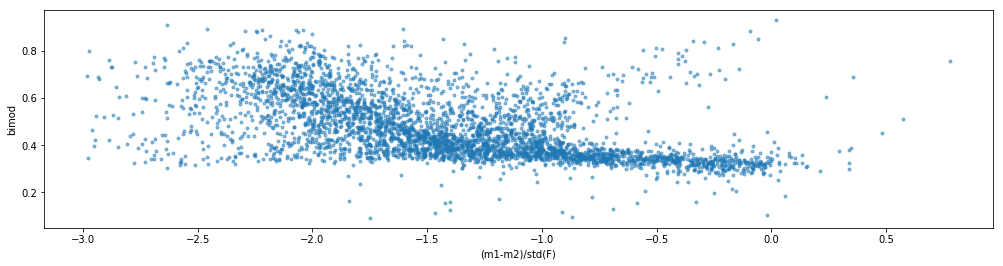

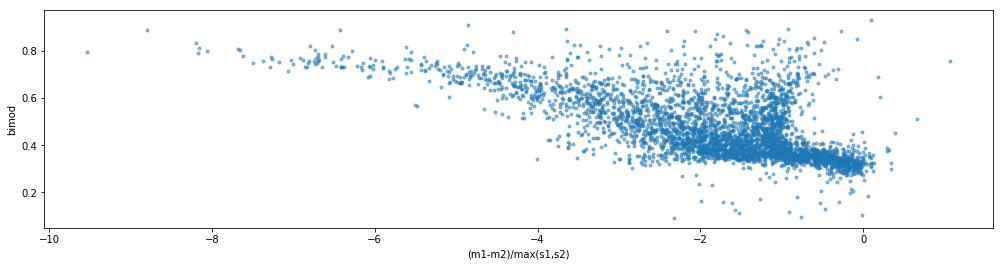

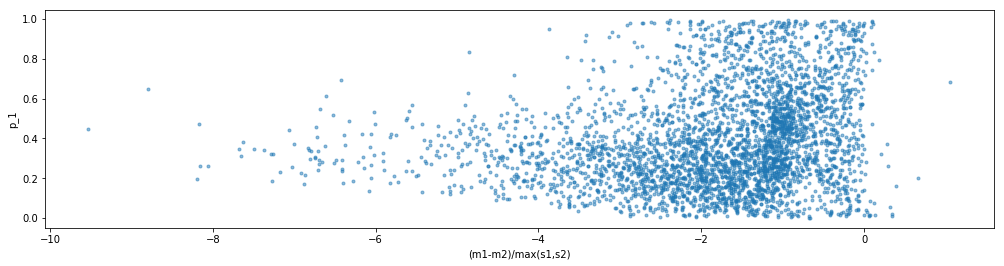

In [18]:
sel = (abs(dgps[:,3]-dgps[:,5])<3)*(dgps[:,2]>0)*(dgps[:,2]<1)
figure(figsize=(17,4))
plot(dgps[sel,3]-dgps[sel,5],ampst[sel,2],'.',alpha=0.5)
xlabel("(m1-m2)/std(F)")
ylabel("bimod")
figure(figsize=(17,4))
s1 = column_stack((dgps[sel,6],dgps[sel,4])).max(axis=1)
#s1 = column_stack((dgps[sel,6],dgps[sel,4])).sum(axis=1)

print(s1.shape)
plot((dgps[sel,3]-dgps[sel,5])/s1,ampst[sel,2],'.',alpha=0.5)
xlabel("(m1-m2)/max(s1,s2)")
ylabel("bimod")
figure(figsize=(17,4))
plot((dgps[sel,3]-dgps[sel,5])/s1,dgps[sel,2],'.',alpha=0.5)
xlabel("(m1-m2)/max(s1,s2)")
ylabel("p_1")

In [19]:
def conditionnumber(a,D):
    if a<0.1:
        return(0)
    if a>0.1 and a<0.4:
        return(1)
    if a>0.4 and a<1.0 and D<1e-2:
        return(2)
    if a>1.0 and a<3.0 and D>1e-2:
        return(3)
    if a>1.0 and a<3.0 and D<1e-2:
        return(4)
    if a>3.0:
        return(5)
    return(6)

    
def conditionlabel(i):
    if i==0:
        return("Amp/Bg<0.1")
    if i==1:
        return("0.1< Amp/Bg <0.4")
    if i==2:
        return("0.4< Amp/Bg <1.0 & D0<0.01 um2/s")
    if i==3:
        return("1< Amp/Bg <3 & D0>0.01 um2/s")
    if i==4:
        return("1< Amp/Bg <3 & D0<0.01 um2/s")
    if i==5:
        return("Amp/Bg>3")
    if i==6:
        return("Others")

#sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)
#sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)
#sel0 = (ampst[:,0]/ampst[:,1]>3.0)
#conditionnumber(0.5,0.6)

In [24]:
len(dataL)

3

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


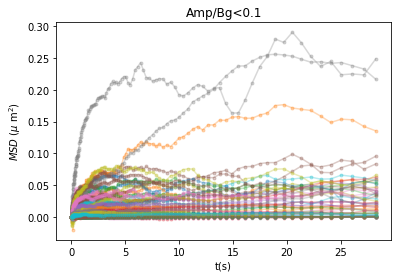

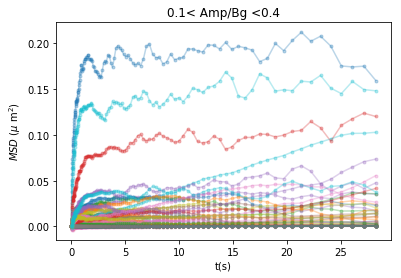

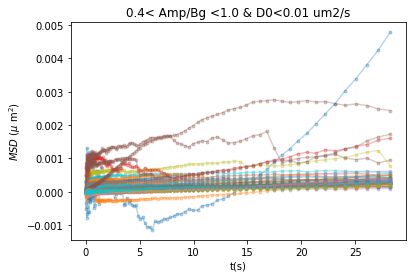

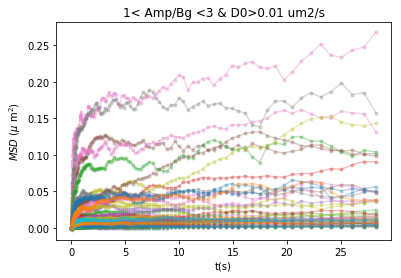

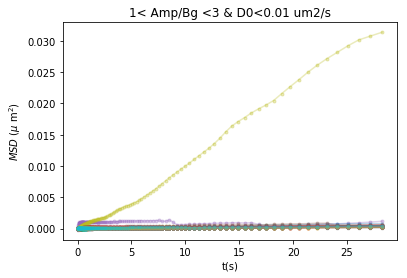

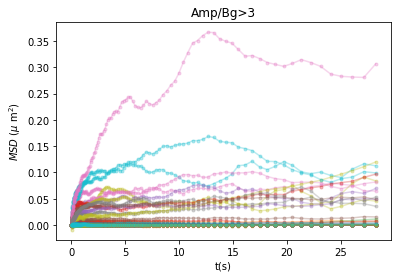

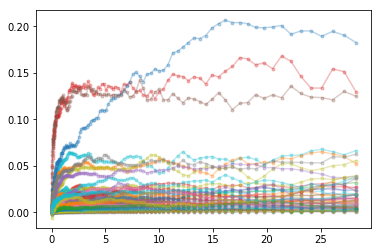

In [46]:
for idat,data in enumerate(dataL):
    tmax = data[0][1].shape[0]

    t = arange(tmax)


    for ic in range(6):
        figure(ic)
        title(conditionlabel(ic))

    cmapt = get_cmap('tab20')

    counter = zeros(7)
    k = 0
    for i in range(len(data)):
        d = data[i]
        ni,yt,ey2,cnt = d

        xtt = t*10.0e-3
        ytt = yt*.325**2

        dto =  log(tmax)/200
        tml = log(t[1:])
        ntl = int(tml[-1]/dto)+1
        t0l = 0
        dd = zeros((ntl,2))-1
        dd[0,:2] = (t[1],ytt[1])
        for il in arange(1,ntl):
            til = t0l+dto
            sel = (tml>=t0l)*(tml<til)
            if sel.sum()>0:
                xe = xtt[1:][sel]
                ye = ytt[1:][sel]
                dd[il,:2] = [mean(xe),mean(ye)]
            t0l = til

        dde = dd[dd[:,0]>0,:]
        dde = dde[1:,:]

        if idat == 0 and i ==0:
            xde = column_stack((dde,dde[:,:1]*0+i,dde[:,:1]*0+idat))
            xden = column_stack((dde[:,:1],(dde[:,1:2]-dde[0,1])/(dde[-1,1]-dde[0,1]),dde[:,:1]*0+i,dde[:,:1]*0+idat))
        else:
            xde = row_stack((xde,column_stack((dde,dde[:,:1]*0+i,dde[:,:1]*0+idat))))
            xden = row_stack((xden,column_stack((dde[:,:1],(dde[:,1:2]-dde[0,1])/(dde[-1,1]-dde[0,1]),dde[:,:1]*0+i,dde[:,:1]*0+idat))))

        ntle = dde.shape[0]
        nwin = 50
        ds = zeros((ntle+nwin-3,3))
        for il in range(ntle+nwin-3):
            sel = arange(il-nwin+3,il+3)
            sel = sel[(sel>=0)*(sel<ntle)]
            xe = dde[sel,0]
            ye = dde[sel,1]    
            lm = linregress(xe,ye)
            ds[il,0] = mean(xe)    
            ds[il,1:3] = (lm.slope,lm.stderr)    

        #print(i)

        xt = ds
        xt = xt[xt[:,1]>0,:]
        De = array([mean(xt[xt[:,0]<1e-1,1]),exp(mean(log(xt[xt[:,0]<1e-1,1])))])

        ic = conditionnumber(ampst[i,0]/ampst[i,1],De[0])
        if counter[ic]< 20:
            figure(ic)
            plot(dde[:,0],dde[:,1]-dde[0,1],'.-',alpha=0.3,label=i)
            counter[ic] +=1

        if idat == 0 and i ==0:
            xds = column_stack((ds,ds[:,:1]*0+i,ds[:,:1]*0+idat))
        else:
            xds = row_stack((xds,column_stack((ds,ds[:,:1]*0+i,ds[:,:1]*0+idat))))

xds = array(xds)
xde = array(xde)
xden = array(xden)

#yscale("log")
#xscale("log")

for ic in range(6):
    figure(ic)
    xlabel("t(s)")
    ylabel("$MSD$ ($\mu$ m$^2$)")



In [47]:
xds[:,-1]

array([0., 0., 0., ..., 2., 2., 2.])

In [49]:
for idat,data in enumerate(dataL):
    
    ts = array([100,200,400,800,1600,3200,6400,12800])/1000.0
    xt = xde[(abs(xde[:,-2]-0)<1e-3)*(abs(xde[:,-1]-idat)<1e-3),0]
    idxts = zeros(ts.shape[0],dtype=int)
    idx = arange(xt.shape[0])
    for i in range(len(ts)):
        idxts[i] = idx[argmin(abs(xt-ts[i]))]

    alphas = zeros((len(data),7))
    alphalm = zeros((len(data),2))

    Det0 = zeros((len(data),3))
    Det1 = zeros((len(data),6))

    for i in range(len(data)):
        xt = xds[(abs(xds[:,-2]-i)<1e-3)*(abs(xds[:,-1]-idat)<1e-3),:]
        xt = xt[xt[:,1]>0,:]
        try:
            De = array([mean(xt[xt[:,0]<2e-1,1]),mean(xt[xt[:,0]<2e-1,2]),max(xt[xt[:,0]<2e-1,2])])
            sel = (xt[:,0]>2e-1)*(xt[:,0]<1.5e0)
            De2 = array([mean(xt[sel,1]),mean(xt[sel,2]),max(xt[sel,2])])
            sel = (xt[:,0]>1.5e0)*(xt[:,0]<1.5e1)
            De3 = array([mean(xt[sel,1]),mean(xt[sel,2]),max(xt[sel,2])])

            xt = xde[(abs(xde[:,-2]-i)<1e-3)*(abs(xde[:,-1]-idat)<1e-3),:]    
            msds = xt[idxts,:]
            msds = msds[1:,:]/msds[:-1,:]
            alpha = log(msds[:,1])/log(msds[:,0])
            lm = linregress(log(msds[:,0]).cumsum(),alpha)
            alphas[i,:] = alpha
            alphalm[i,:] = (lm.slope,lm.intercept)
            Det0[i,:] = De
            Det1[i,:] = concatenate((De2,De3))
        except:
            pass
    if idat ==0:
        Des = column_stack((Det0,Det0[:,0]*0+idat))
        Dep = column_stack((Det1,Det1[:,0]*0+idat))
    else:
        Des = row_stack((Des,column_stack((Det0,Det0[:,0]*0+idat))))
        Dep = row_stack((Dep,column_stack((Det1,Det1[:,0]*0+idat))))
        

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [50]:
#xde[300:320,-2:]

In [51]:
ts = array([100,200,400,800,1600,3200,6400,12800])/1000.0
xt = xde[(abs(xde[:,-2]-0)<1e-3)*(abs(xde[:,-1]-idat)<1e-3),0]
print(xt)
idxts = zeros(ts.shape[0],dtype=int)
idx = arange(xt.shape[0])
for i in range(len(ts)):
    idxts[i] = idx[argmin(abs(xt-ts[i]))]

[1.0000e-02 2.0000e-02 3.0000e-02 4.0000e-02 5.0000e-02 6.0000e-02
 7.0000e-02 8.0000e-02 9.0000e-02 1.0000e-01 1.1000e-01 1.2000e-01
 1.3000e-01 1.4000e-01 1.5000e-01 1.6000e-01 1.7000e-01 1.8000e-01
 1.9000e-01 2.0000e-01 2.1000e-01 2.2000e-01 2.3000e-01 2.4000e-01
 2.5000e-01 2.6000e-01 2.7000e-01 2.8000e-01 2.9500e-01 3.1000e-01
 3.2000e-01 3.3000e-01 3.4500e-01 3.6000e-01 3.7500e-01 3.9000e-01
 4.0500e-01 4.2500e-01 4.4000e-01 4.5500e-01 4.7500e-01 4.9500e-01
 5.1500e-01 5.3500e-01 5.6000e-01 5.8500e-01 6.0500e-01 6.3000e-01
 6.5500e-01 6.8000e-01 7.1000e-01 7.4000e-01 7.7000e-01 8.0000e-01
 8.3500e-01 8.7000e-01 9.0500e-01 9.4000e-01 9.7500e-01 1.0150e+00
 1.0600e+00 1.1050e+00 1.1500e+00 1.1950e+00 1.2400e+00 1.2950e+00
 1.3500e+00 1.4050e+00 1.4650e+00 1.5250e+00 1.5850e+00 1.6500e+00
 1.7150e+00 1.7850e+00 1.8600e+00 1.9350e+00 2.0150e+00 2.0950e+00
 2.1800e+00 2.2700e+00 2.3600e+00 2.4550e+00 2.5550e+00 2.6600e+00
 2.7700e+00 2.8850e+00 3.0050e+00 3.1250e+00 3.2500e+00 3.3850

In [52]:
xde

array([[1.00000000e-02, 1.03770216e-05, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-02, 9.85532788e-06, 0.00000000e+00, 0.00000000e+00],
       [3.00000000e-02, 9.99630327e-06, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.60850000e+01, 2.81531152e-01, 8.52000000e+02, 2.00000000e+00],
       [2.71500000e+01, 2.79849055e-01, 8.52000000e+02, 2.00000000e+00],
       [2.82600000e+01, 2.76282162e-01, 8.52000000e+02, 2.00000000e+00]])

In [53]:
import seaborn as sns
sns.set(style="white", color_codes=True)

In [54]:
De.shape

(3,)

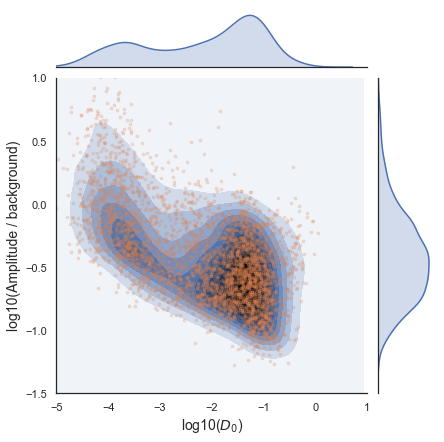

In [55]:
yt = ampst[:,0]/ampst[:,1]
xt = Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

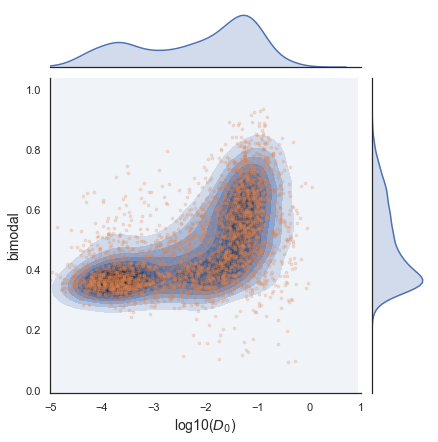

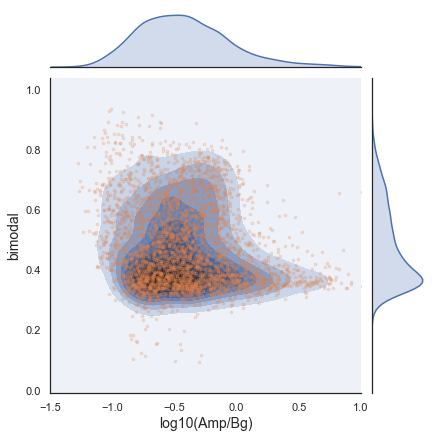

In [56]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

#g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

yt = ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
#g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

<Figure size 432x288 with 0 Axes>

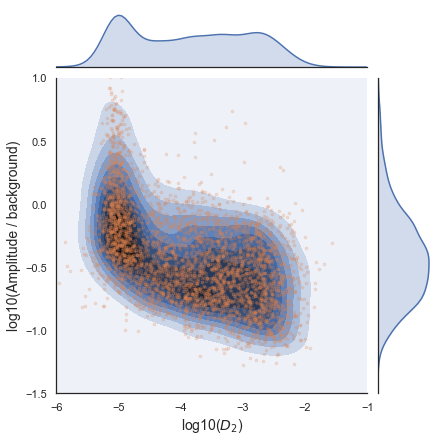

In [57]:
yt = ampst[:,0]/ampst[:,1]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
fig = figure()
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

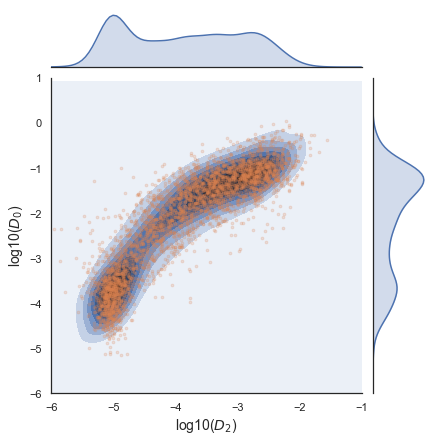

In [58]:
yt = Des[:,0]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-6,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10($D_0$)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

In [62]:
dfilesF = []
for i,dirt in enumerate(nwdirs):
    basedir = dirt
    files = os.listdir(basedir)
    dfiles = []
    if driftcorrected:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfiles.append(basedir+f)
    else:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfiles.append(basedir+f)
    dfiles.sort()
    dfilesF.extend(dfiles)
dfiles = dfilesF

In [63]:
yt = 1.0*ampst[:,0]/ampst[:,1]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = log10(yt[sel])


NRs selected:  [3802 2928  672]


Text(0.5,0,'t')

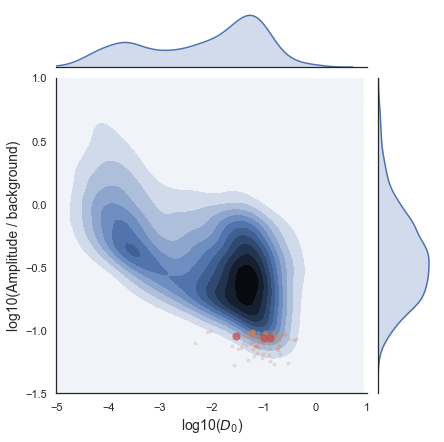

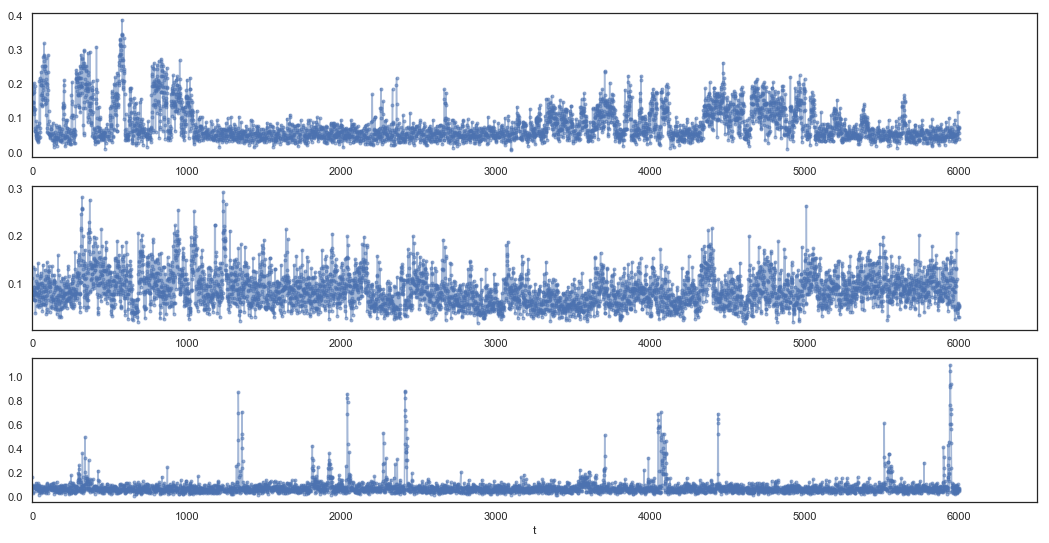

In [64]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = ampst[:,0]/ampst[:,1]<0.1

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)


it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)
print('NRs selected: ' ,it)

#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
#fig.title("Amplitude/Background < 0.1")
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [65]:
sel = ampst[:,0]/ampst[:,1]<0.1
it = permutation(arange(len(xt))[sel])[:3]
print(it,idx0[it])

[3793 2927 2906] [3804 2932 2911]


NRs selected:  [2844 3238  376]


Text(0.5,0,'t')

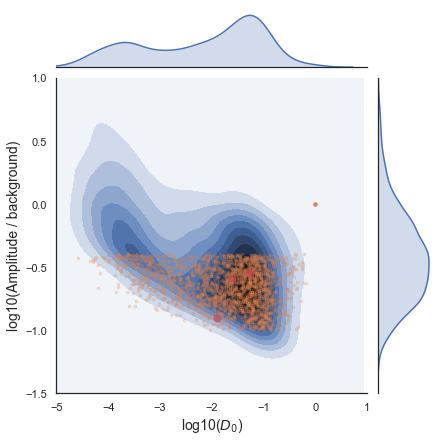

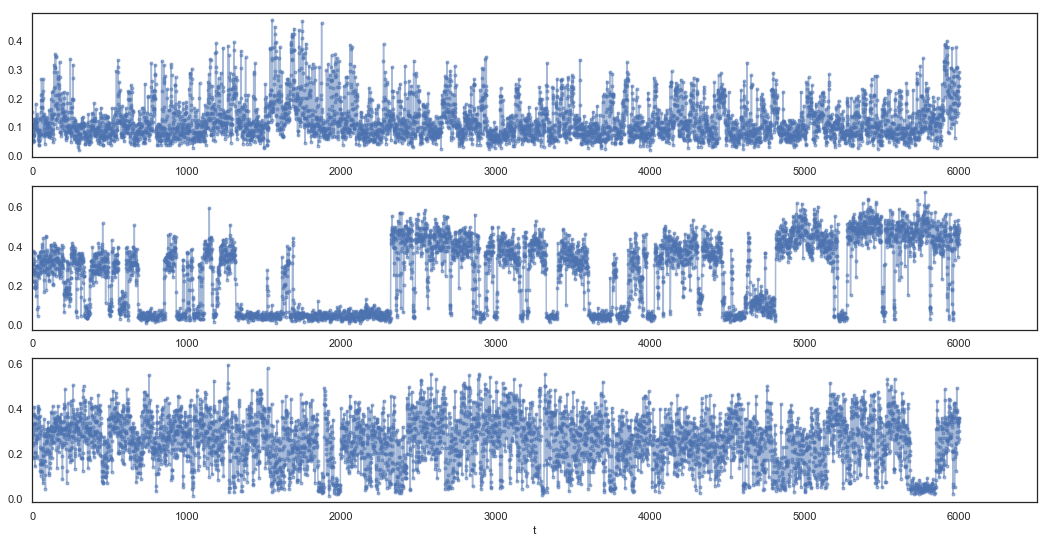

In [66]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [3487  146 3019]


Text(0.5,0,'t')

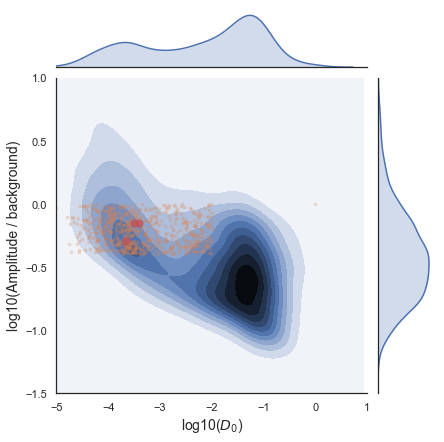

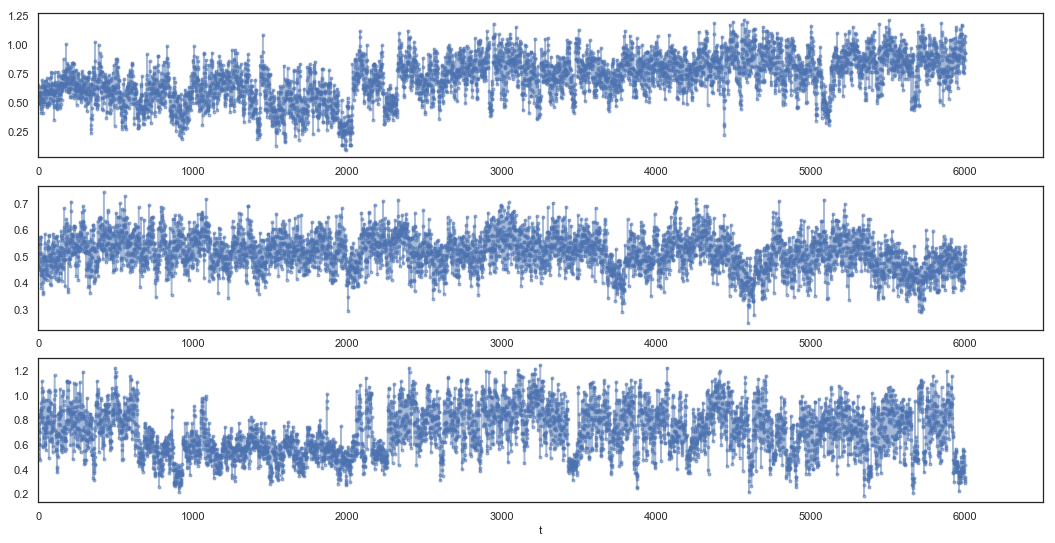

In [68]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [2252   89 3465]


Text(0.5,0,'t')

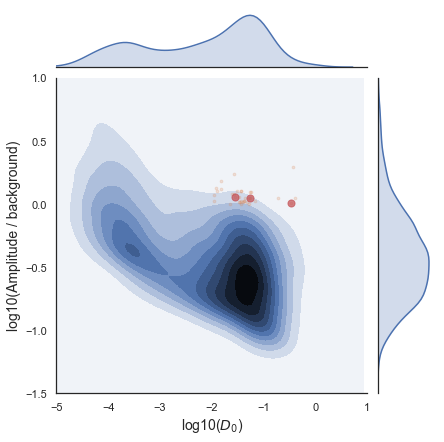

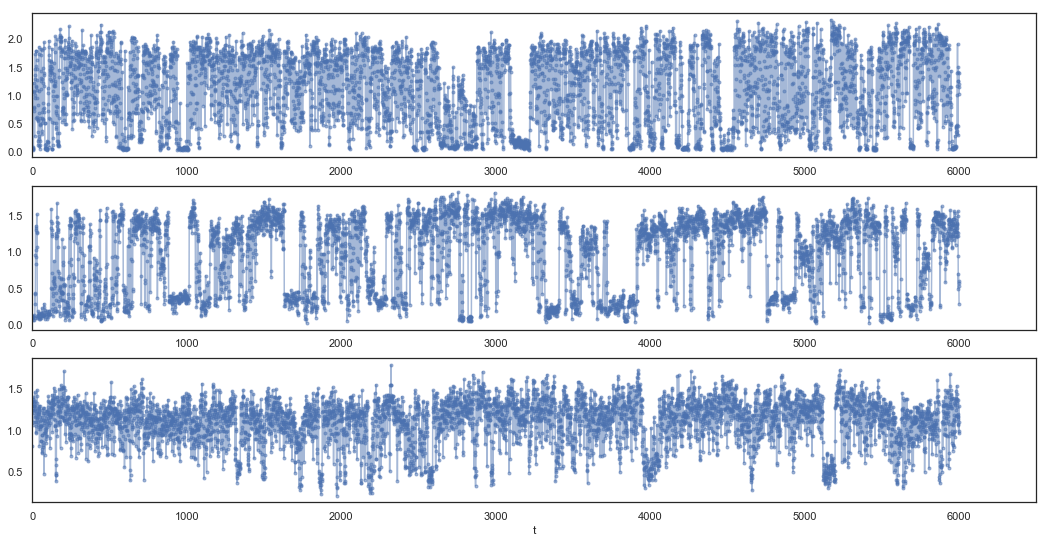

In [69]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [2260 2194   23]


Text(0.5,0,'t')

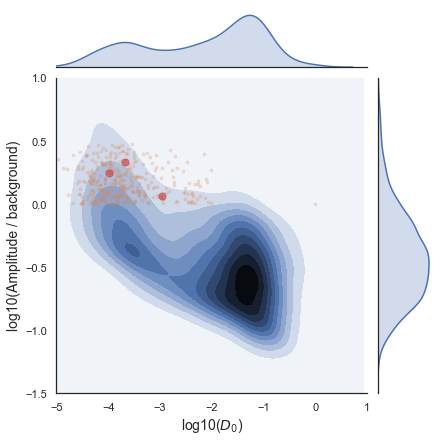

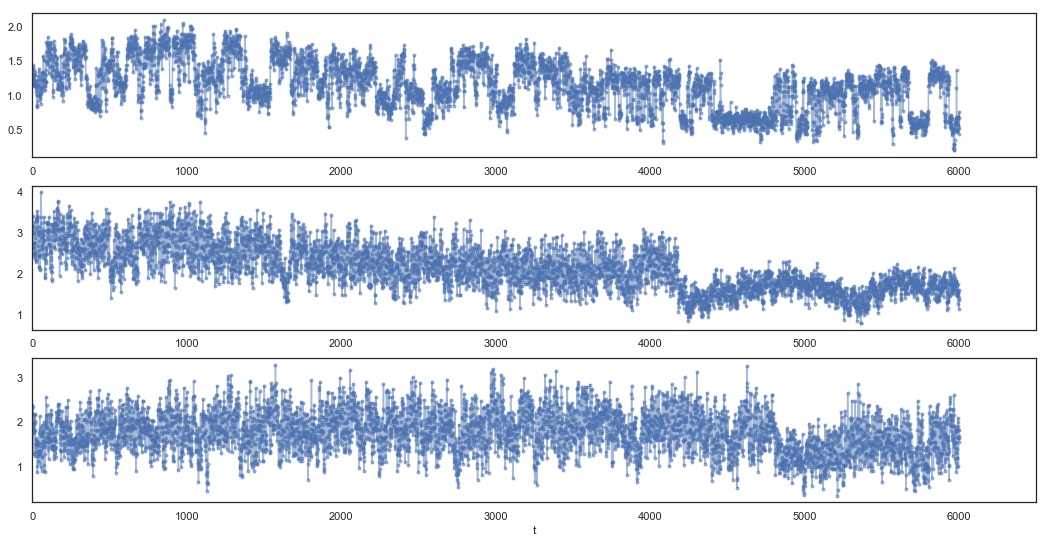

In [70]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
#fig = figure(figsize=(14,8))
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [71]:
print(log10(ampst[254,0]/ampst[254,1]),log10(Des[254,0]))

-0.43091703270050397 -1.2470955453912347


NRs selected:  [2178 3418 2167]


Text(0.5,0,'t')

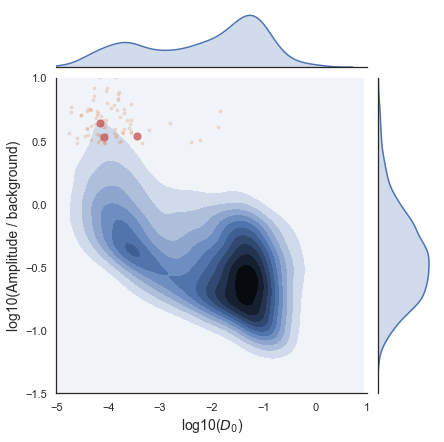

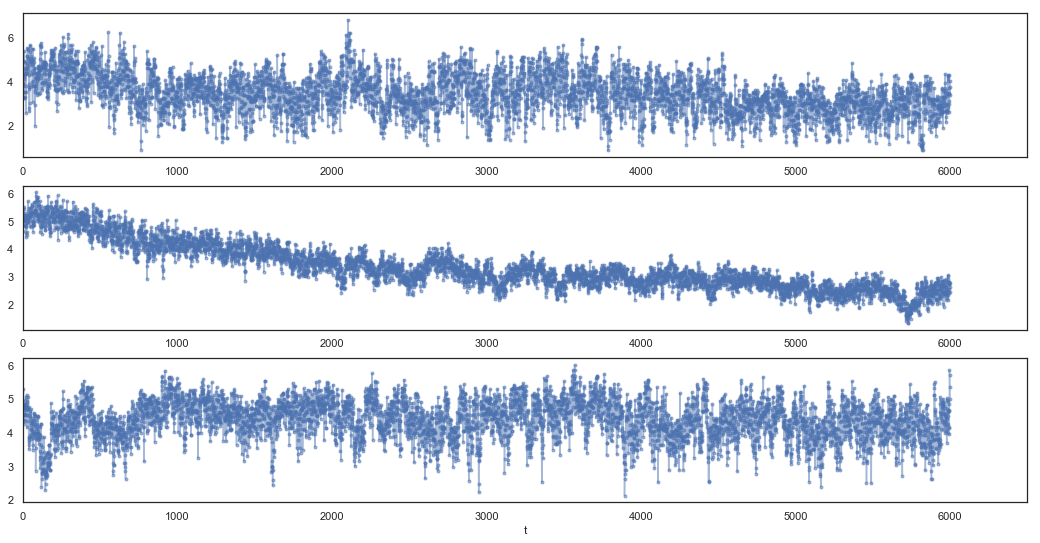

In [72]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>3.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [73]:
yt = 1.0*ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])

NRs selected:  [1704 3680 2907]


Text(0.5,0,'t')

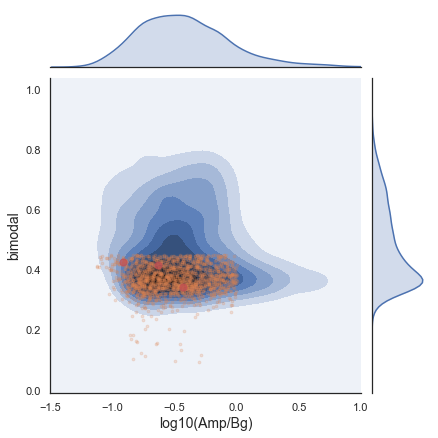

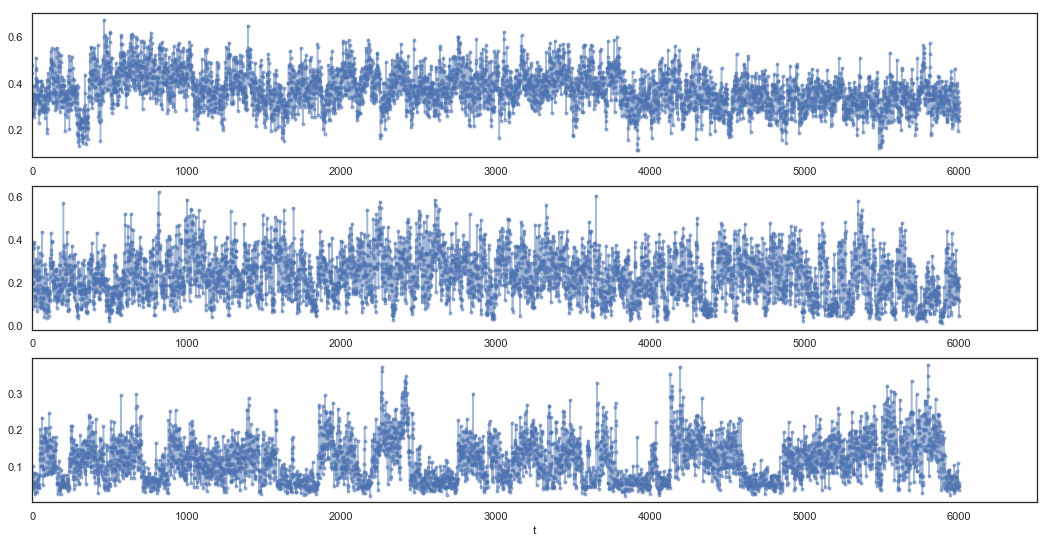

In [74]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(ampst[:,0]/ampst[:,1]<1.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [75]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [76]:
%matplotlib inline

NRs selected:  [ 710 3645  398]


Text(0.5,0,'t')

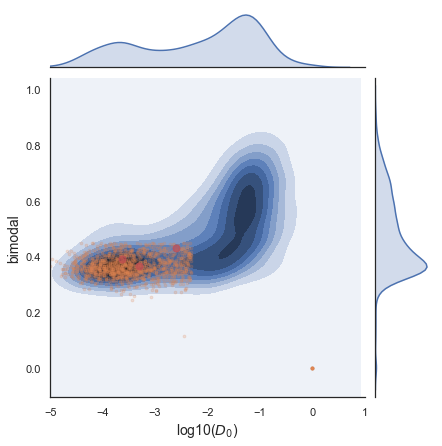

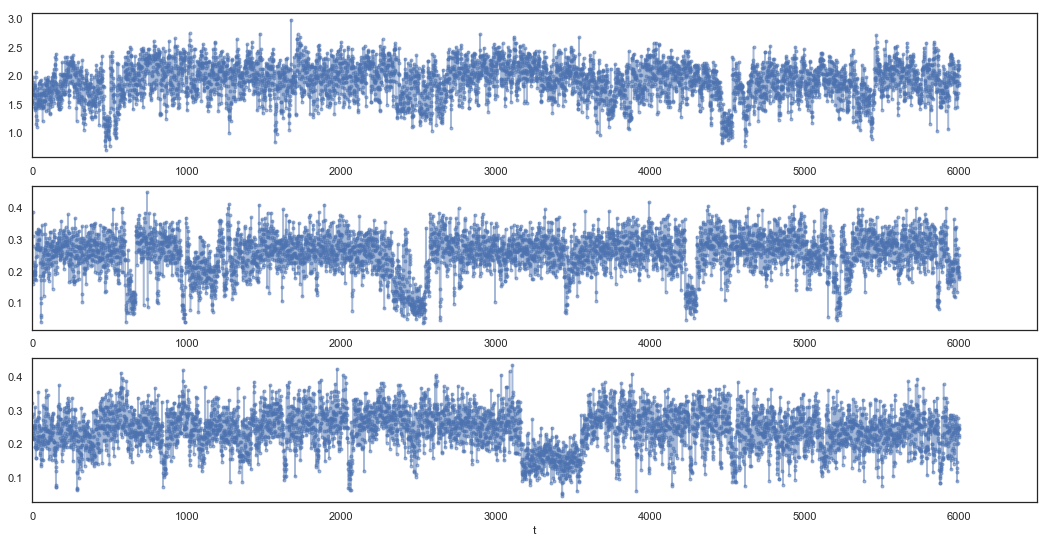

In [77]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [78]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [79]:
%matplotlib inline

NRs selected:  [2520  410 1992]


Text(0.5,0,'t')

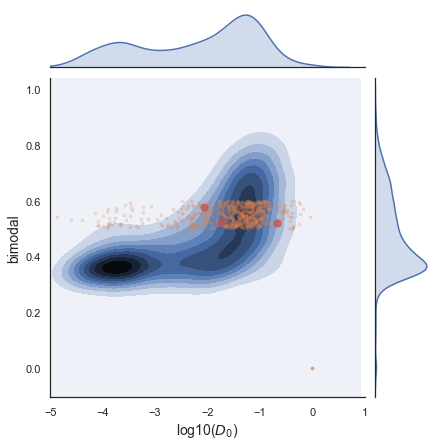

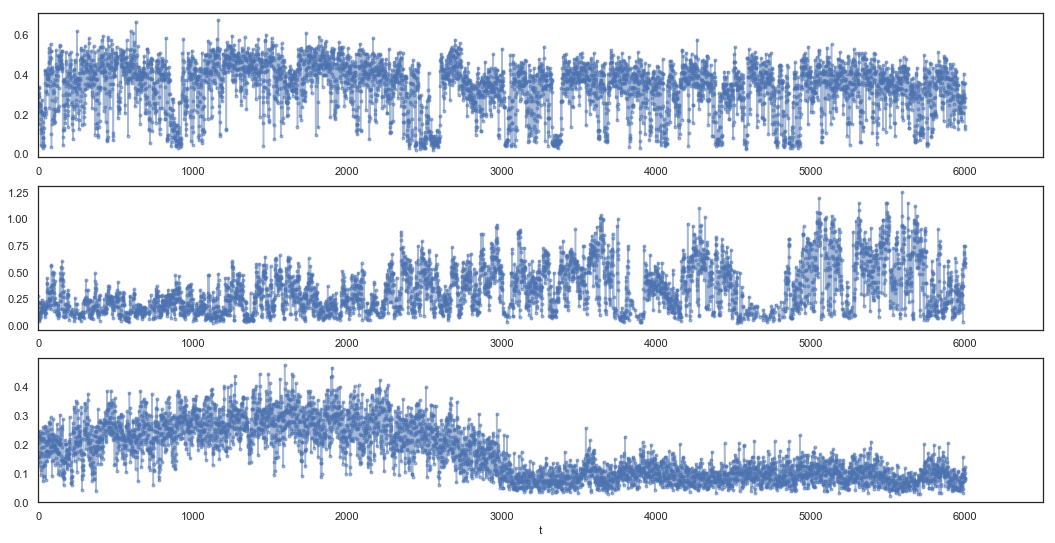

In [80]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [81]:
%matplotlib inline

NRs selected:  [1269  164 2604]


Text(0.5,0,'t')

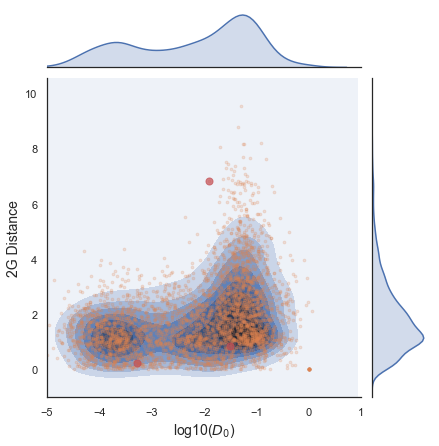

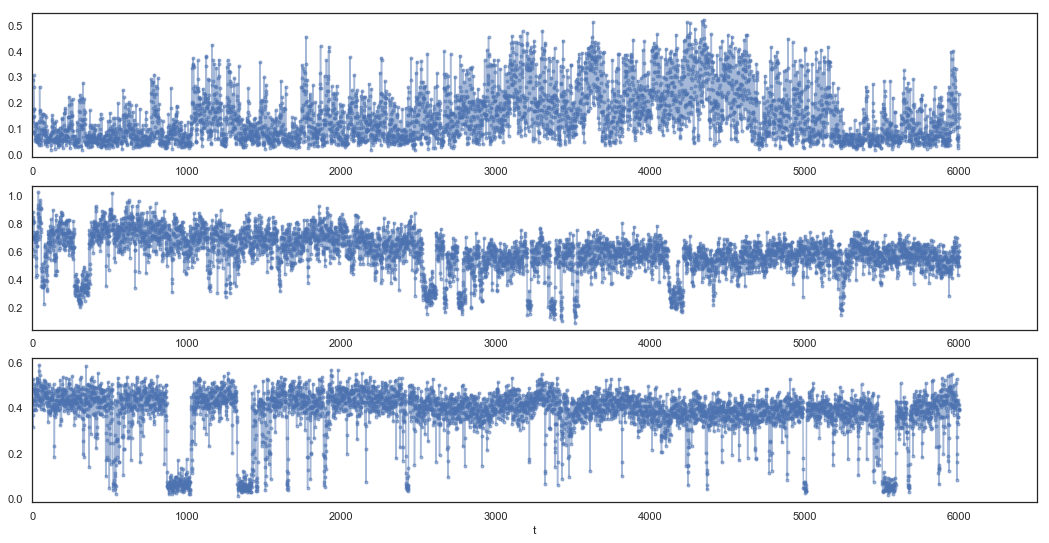

In [82]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = isfinite(ampst[:,2])#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [2370 3371  791]


Text(0.5,0,'t')

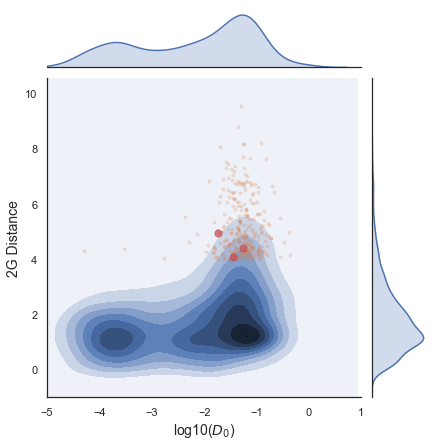

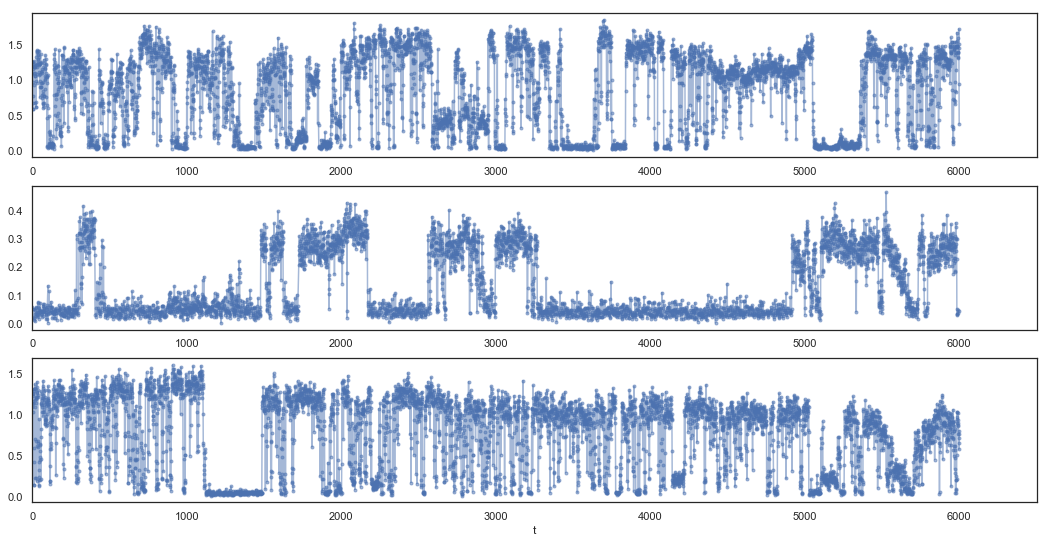

In [83]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = yt>4#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [3330 1546 2110]


Text(0.5,0,'t')

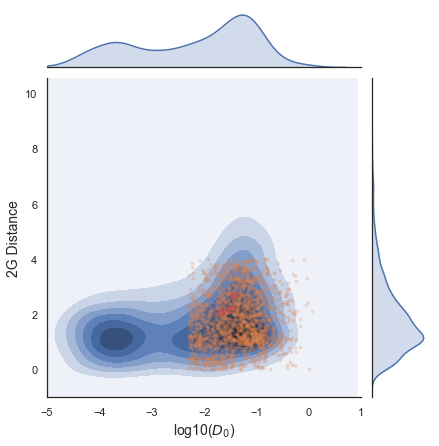

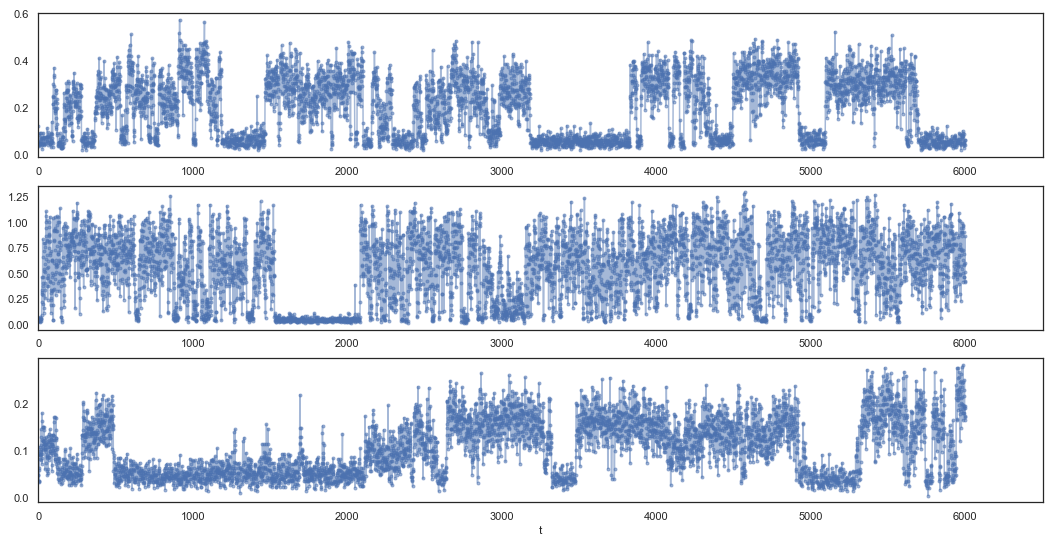

In [84]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = (yt<4)*(Des[:,0]>.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [259 838  75]


Text(0.5,0,'t')

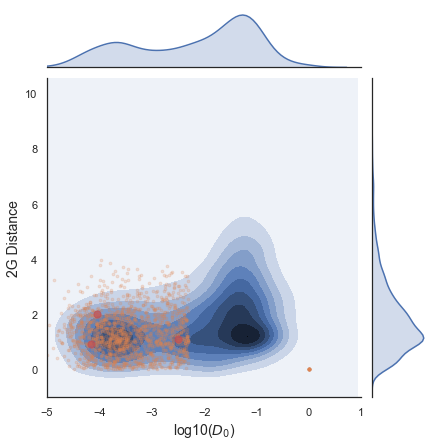

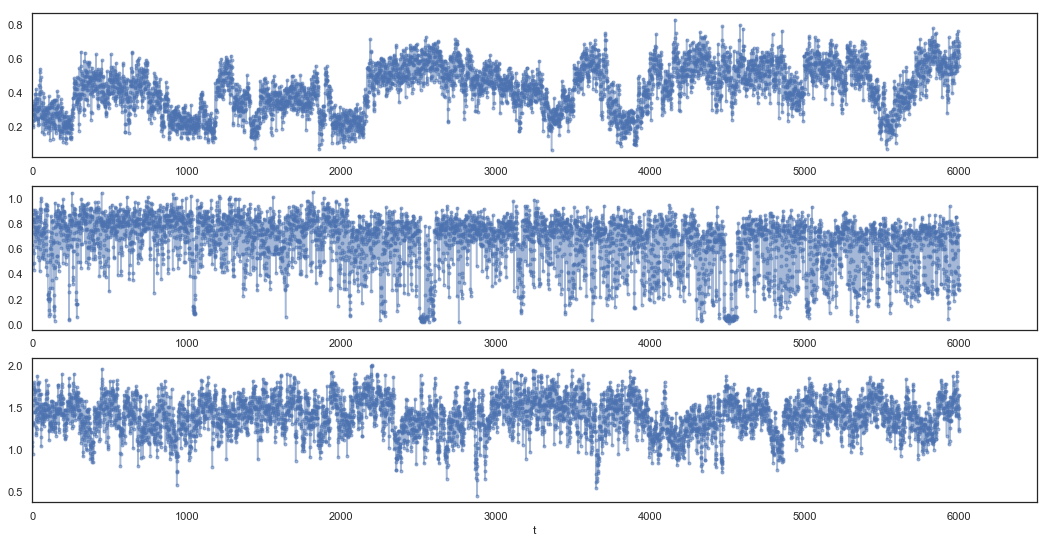

In [85]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = (yt<4)*(Des[:,0]<.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 184 3441 2307]


Text(0.5,0,'t')

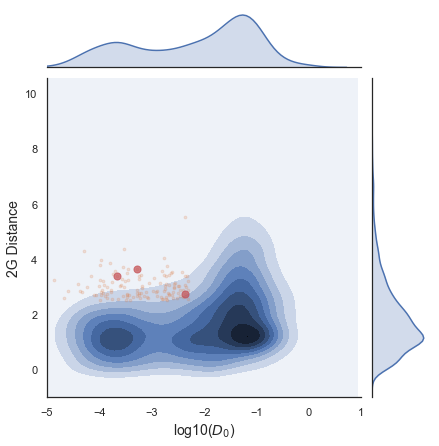

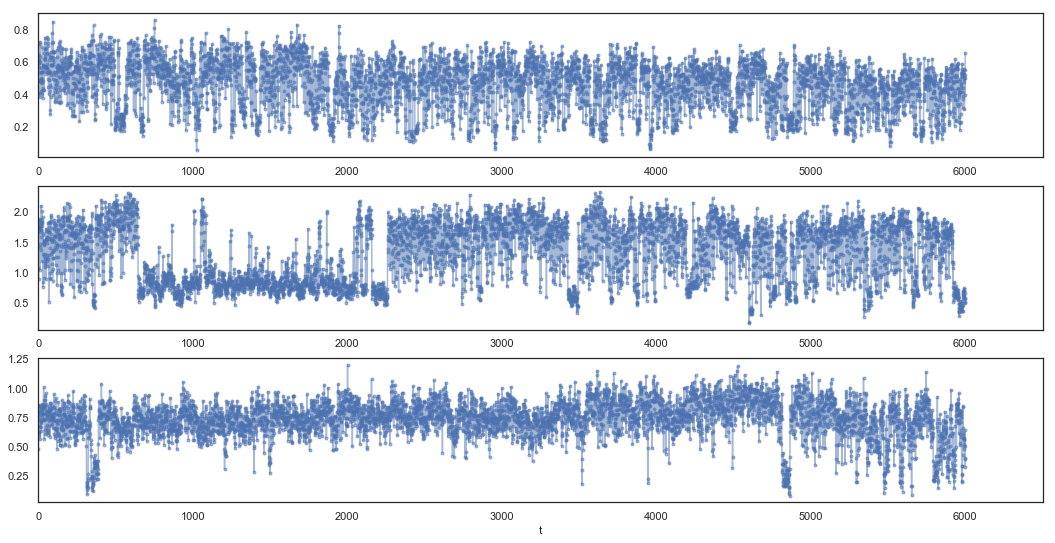

In [89]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = (yt>2.5)*(Des[:,0]<.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [86]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
zt = 1.0*ampst[:,2]
at = ampst[:,0]/ampst[:,1]
at2 = (dgps[:,0]+dgps[:,1]*column_stack((dgps[:,3],dgps[:,5])).max(axis=1))/ampst[:,1]
xt = 1.0*Des[:,0]
xt2 = Dep[:,0]
xt3 = Dep[:,3]
sel = (xt>0)*(xt2>0)*(xt3>0)*(zt>0)*(abs(yt)<20)
xt = log10(xt[sel])
xt2 = log10(xt2[sel])
xt3 = log10(xt3[sel])
yt = yt[sel] #log10(yt[sel])
zt = zt[sel]
at = log10(at[sel])
at2 = log10(at2[sel])
#  (m1-m2)/max(s1,s2), bimod, A/bg, A_on/bg, D0, D1, D2
data = column_stack((yt,zt,at,at2,xt,xt2,xt3))
savetxt('stats_temp.dat',data,header='#  (m1-m2)/max(s1,s2), bimod, A/bg, A_on/bg, D0, D1, D2')